## Project: ANPR

ANPR stands for"Automatic License Plate Recognition" systems are used to automatically detect and recognize license plates in images. From there, the identified license plate can be used to look up information on the owner of the car.
ANPR systems are mainly used for automatic toll collection,  the primary use of ANPR is within law enforcement to issue speeding citations.<br/>

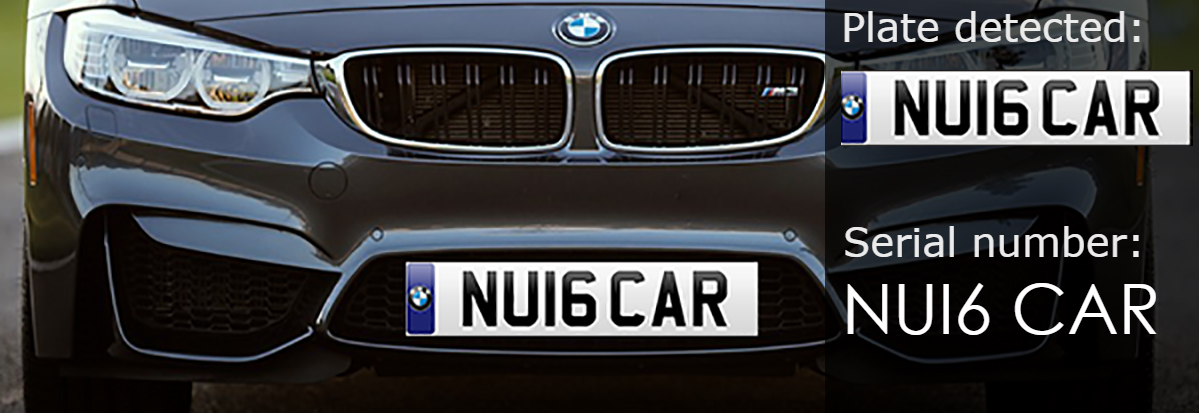

In [1]:
from IPython.display import Image
Image(filename='markdown_use/showcase.jpg') 

### Import dependencies

In [2]:
from collections import namedtuple
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpImg
from imutils import perspective
import imutils
from skimage.filters import threshold_adaptive
from skimage import segmentation
from skimage import measure
%matplotlib inline

### Dataset
I will be using the Medialab dataset for this project maintained by the National Technical University of Athens in Greece with 139 images.

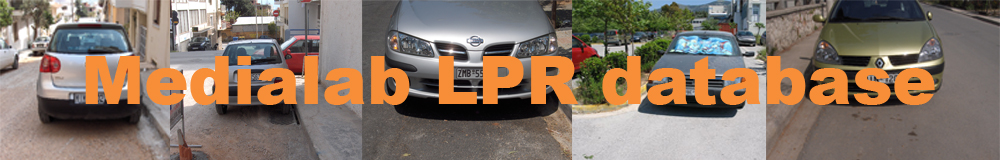

In [3]:
from IPython.display import Image
Image(filename='markdown_use/banner.jpg') 

#### Loading the dataset

In [4]:
list = glob.glob('testing_lp_dataset/*.jpg')

### Custom namedtuple
A custom namedtuple class is to keep track of every plate in a given image.

In [5]:
LicensePlate = namedtuple("LicensePlateRegion", ["success", "plate", "thresh", "candidates"])

### Detector class
A detector class has all the methods to detect Automatic License Plate. LicensePlateDetector.detect() is the method to return the plates that are found in a given image.The pipeline has the following steps:<br/>
<li>Localizing the license plate</li>
<li>Segmentation of characters from license plate</li>
<li>Recognition of characters</li>

In [56]:
class LicensePlateDetector:
    
    def __init__(self, minPlateW = 60, minPlateH = 20):
        self.minPlateW = minPlateW
        self.minPlateH = minPlateH    
        self.numChars = 7
        
    def detect(self, image):
        lpRegions =  self.detectPlate(image)
        for lpBox in lpRegions:
            lp = self.detectCharacterCandidates(image, lpBox)
            if lp:
                return lp
                
    def detectCharacterCandidates(self, image, region):
                # apply a 4-point transform to extract the license plate
                plate = perspective.four_point_transform(image, region)
                # extract the Value component from the HSV color space and apply adaptive thresholding
                # to reveal the characters on the license plate
                V = cv2.split(cv2.cvtColor(plate, cv2.COLOR_BGR2HSV))[2]
                thresh = threshold_adaptive(V, 29, offset=15).astype("uint8") * 255
                thresh = cv2.bitwise_not(thresh)

                # resize the license plate region to a canonical size
                plate = imutils.resize(plate, width=400)
                thresh = imutils.resize(thresh, width=400)
                
                labels = measure.label(thresh, neighbors=8, background=0)
                charCandidates = np.zeros(thresh.shape, dtype="uint8")
                overall_cnts = []
                for label in np.unique(labels):
                    # if this is the background label, ignore it
                    if label == 0:
                        continue

                    # otherwise, construct the label mask to display only connected components for the
                    # current label, then find contours in the label mask
                    labelMask = np.zeros(thresh.shape, dtype="uint8")
                    labelMask[labels == label] = 255
                    _, cnts, _ = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    
                    if len(cnts) > 0:
                        # grab the largest contour which corresponds to the component in the mask, then
                        # grab the bounding box for the contour
                        c = max(cnts, key=cv2.contourArea)
                        (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)

                        # compute the aspect ratio, solidity, and height ratio for the component
                        aspectRatio = boxW / float(boxH)
                        solidity = cv2.contourArea(c) / float(boxW * boxH)
                        heightRatio = boxH / float(plate.shape[0])

                        # determine if the aspect ratio, solidity, and height of the contour pass
                        # the rules tests
                        keepAspectRatio = aspectRatio < 1.0
                        keepSolidity = solidity > 0.15
                        keepHeight = heightRatio > 0.4 and heightRatio < 0.95

                        # check to see if the component passes all the tests
                        if keepAspectRatio and keepSolidity and keepHeight:
                            # compute the convex hull of the contour and draw it on the character
                            # candidates mask
                            hull = cv2.convexHull(c)
                            cv2.drawContours(charCandidates, [hull], -1, 255, -1)
                            charCandidates = segmentation.clear_border(charCandidates)
                            
                nonZero_y, nonZero_x = charCandidates.nonzero()
                charCandidates_found = True if nonZero_y.shape[0] != 0 else False 
                
                kernel = np.ones((3,3),np.uint8)
                charCandidates_dilation = cv2.dilate(charCandidates, kernel, iterations = 1)
                charCandidates_erosion = cv2.erode(charCandidates_dilation, kernel, iterations = 1)
                
                if charCandidates_found:
                    prunedCandidates, selected = self.pruneCandidates(charCandidates_erosion)
                    return LicensePlate(success = charCandidates_found, plate = plate, thresh = thresh, candidates = prunedCandidates)
                else:
                    return LicensePlate(success = charCandidates_found, plate = plate, thresh = thresh, candidates = charCandidates)
                            
#                     else:
#                         return None
    
    def detectPlate(self, image):
        # initialize the rectangular and square kernels to be applied to the image,
        # then initialize the list of license plate regions
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

        # convert the image to grayscale, and apply the blackhat operation
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
        
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKernel)
        light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]
        
        # compute the Scharr gradient representation of the blackhat image and scale the
        # resulting image into the range [0, 255]
        gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
        
        gradX = cv2.GaussianBlur(gradX, (15, 15), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
        _, threshold = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        # perform a series of erosions and dilations on the image
        threshold = cv2.erode(threshold, None, iterations=2)
        threshold = cv2.dilate(threshold, None, iterations=2)
        
        threshold = cv2.bitwise_and(threshold, threshold, mask=light)
        threshold = cv2.dilate(threshold, None, iterations=2)
        threshold = cv2.erode(threshold, None, iterations=1)
        
        boxes = self.findContours(threshold)
        return boxes
    
    def pruneCandidates(self, charCandidates):
        # initialize the pruned candidates mask and the list of dimensions
        _, cnts, _ = cv2.findContours(charCandidates, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        prunedCandidates = np.zeros_like(charCandidates, dtype="uint8")
        dims = []

        # loop over the contours
        for c in cnts:
            # compute the bounding box for the contour and update the list of dimensions
            (x, y, w, h) = cv2.boundingRect(c)
            dims.append(x)
            
        # convert the dimensions into a NumPy array and initialize the list of differences
        # and selected contours
        dims = np.array(dims)
        diffs = []
        selected = []
        # loop over the dimensions
        for i in range(0, len(dims)):
            # compute the sum of differences between the current dimension and all other
            # dimensions, then update the differences list
            diffs.append(np.absolute(200 - dims[i]))

        # find the top number of candidates with the most similar dimensions and loop over
        # the selected contours
        for i in np.argsort(diffs)[:self.numChars]:
            # draw the contour on the pruned candidates mask and add it to the list of selected
            # contours
            cv2.drawContours(prunedCandidates, [cnts[i]], -1, 255, -1)
            selected.append(cnts[i])

        # return a tuple of the pruned candidates mask and selected contours
        return (prunedCandidates, selected)
    
    def findContours(self, binaryImg):
        min_ratio_width = 2.5
        max_ratio_width = 6
        regions = []
        output = binaryImg.copy()
        output = np.dstack((output, output, output))
        _, cnts, _  = cv2.findContours(binaryImg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
        # loop over the contours
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            
            aspectRatio = w // h
            #cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
            rect = cv2.minAreaRect(c)
            box = np.int0(cv2.boxPoints(rect))

            # ensure the aspect ratio, width, and height of the bounding box fall within
            # tolerable limits, then update the list of license plate regions
            if (aspectRatio > min_ratio_width and aspectRatio < max_ratio_width) and h > self.minPlateH and w > self.minPlateW:
#                 regions.append([[x, y], [x, y + h], [x + w, y + h], [w + h, y]])
                regions.append(box)
                
        return regions
    
    def getCharacters(self, image, candidates):
        _, cnts, _  = cv2.findContours(candidates.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        location_x = []
        location_y = []
        width = []
        height = []
        sorted_cnts = []
        #排序cnts的順序,所以他們會由X的大小作排列
        for cnt in cnts:
            x, y, w, h = cv2.boundingRect(cnt)
            location_x.append(x)
            location_y.append(y)
            width.append(w)
            height.append(h)
        
        sorted_cnts = sorted(zip(location_x, location_y, width, height), key = lambda x:x[0])
        return sorted_cnts
            
        
            
        
        
clsfier = LicensePlateDetector()

## Test on dataset
Almost all of the methods i use to detect car plates and extract characters are defined, it's time to see how it works out.

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


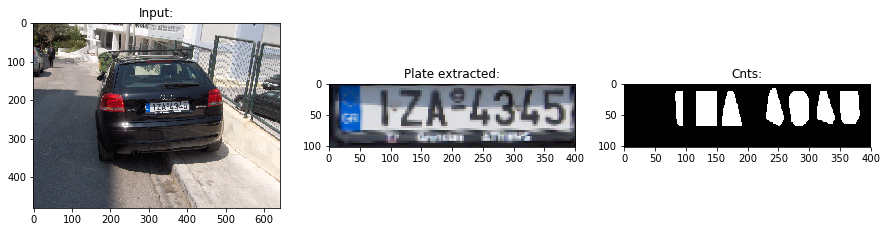

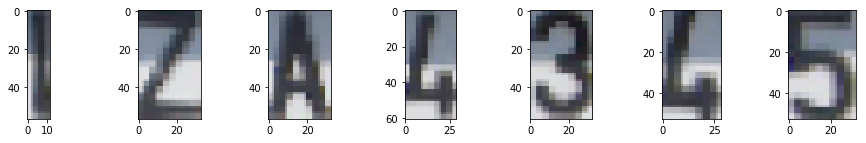

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


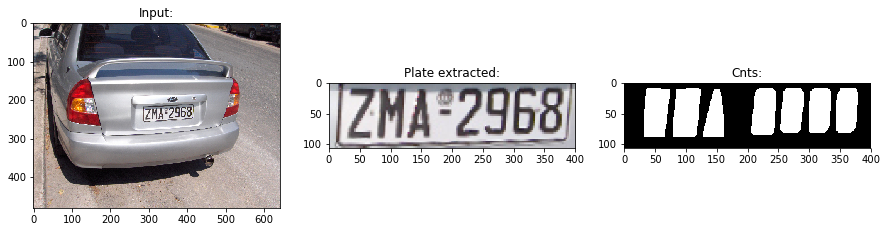

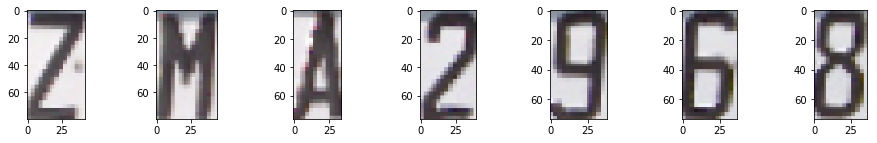

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


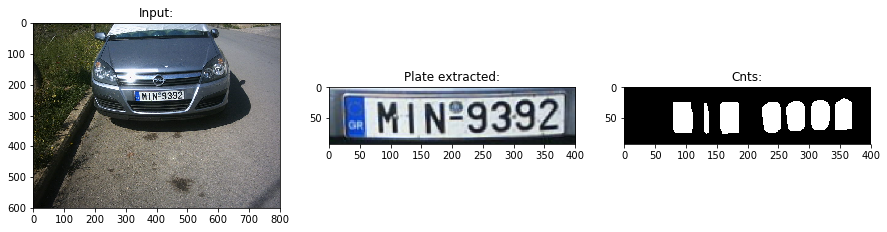

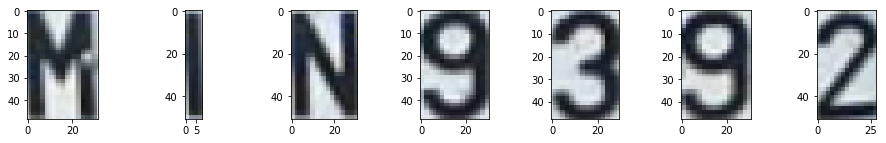

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


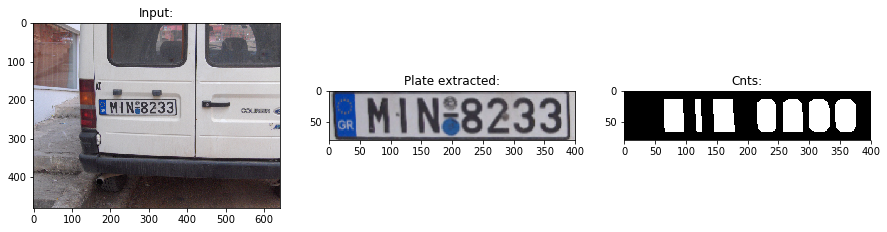

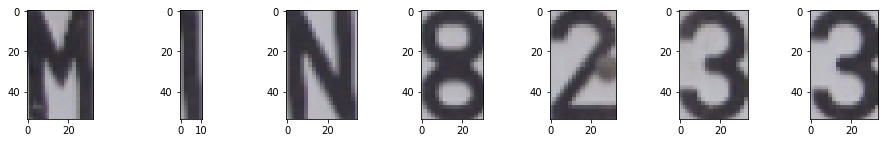

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


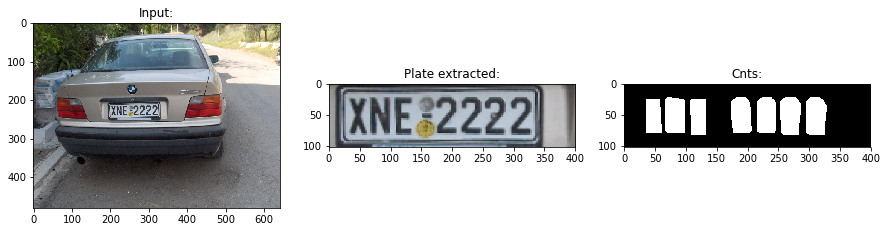

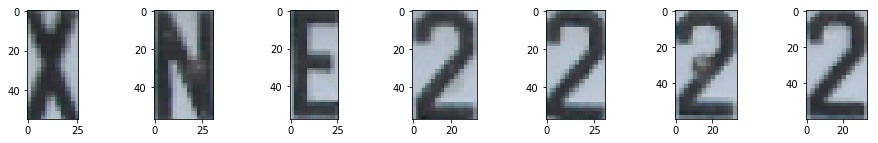

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


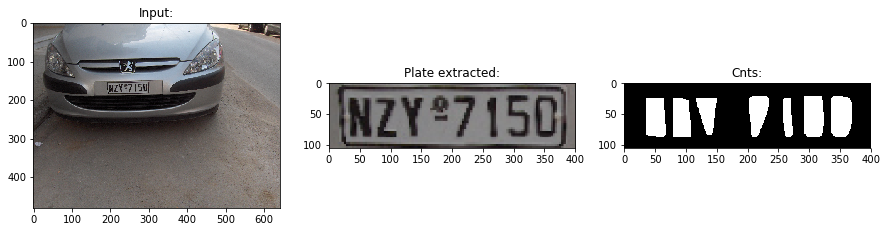

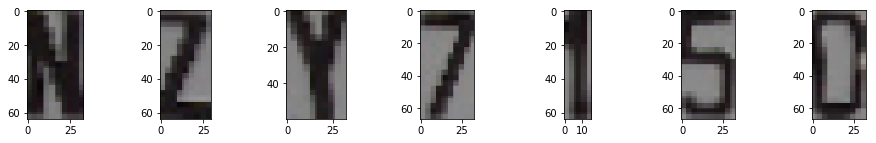

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is not found in this image


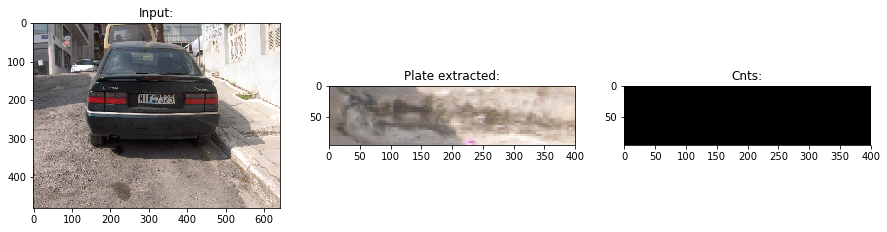

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


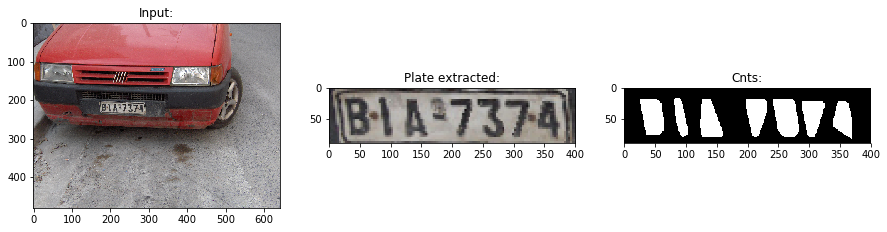

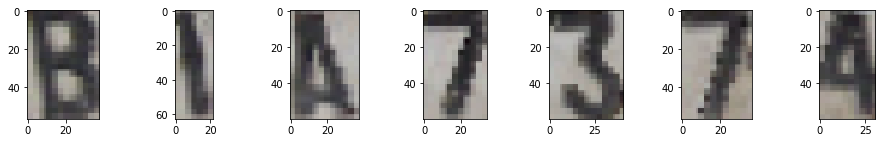

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


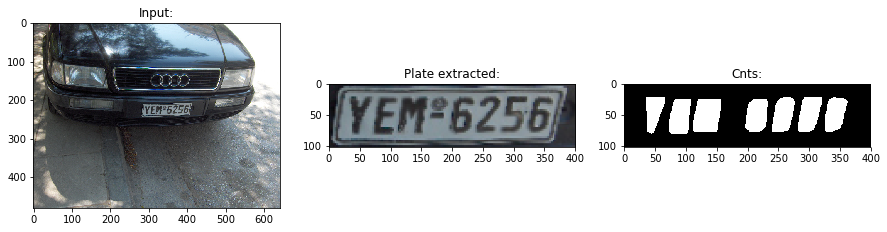

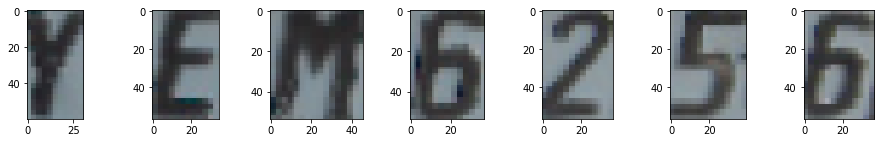

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


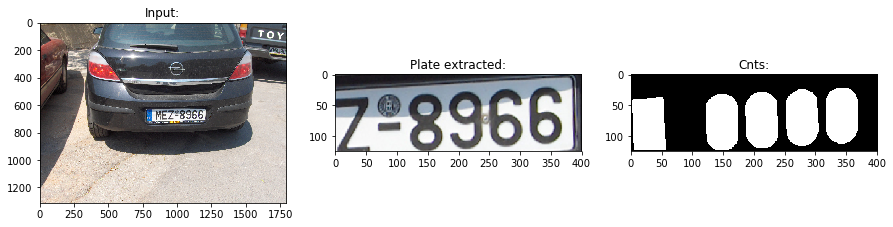

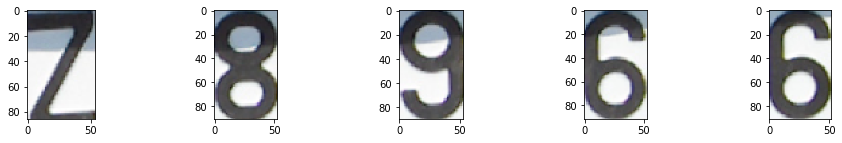

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


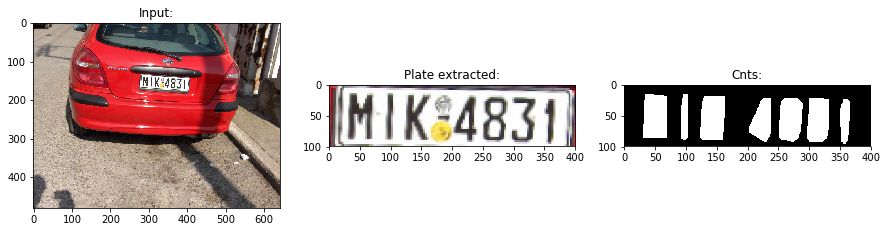

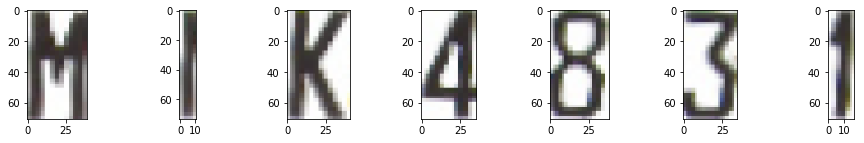

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


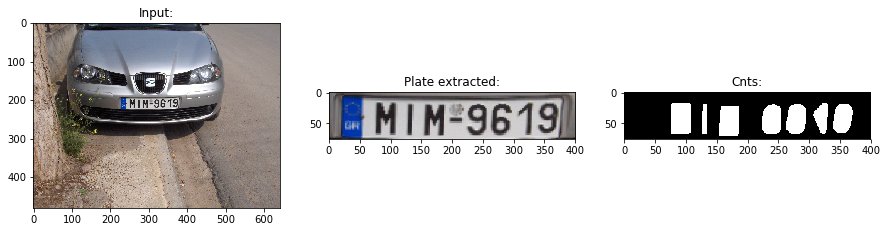

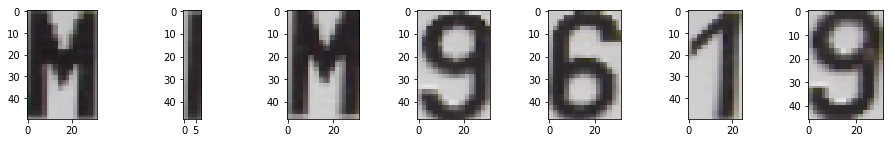

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


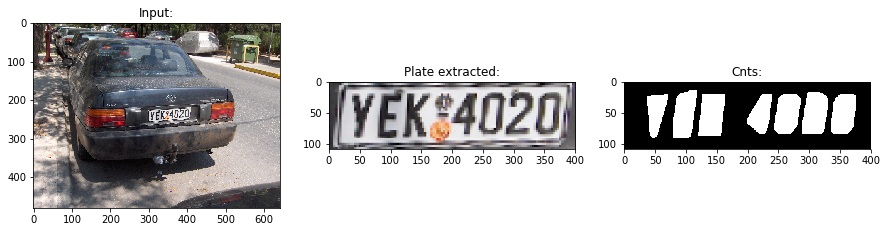

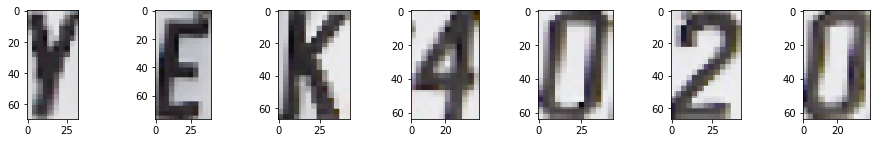

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


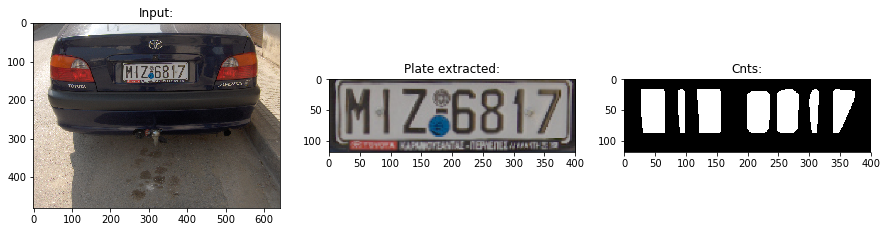

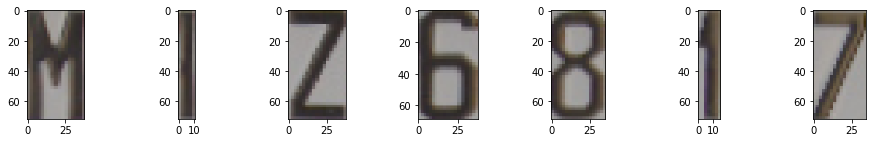

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is not found in this image


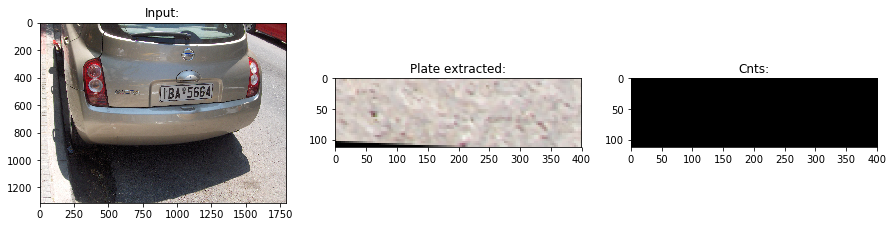

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


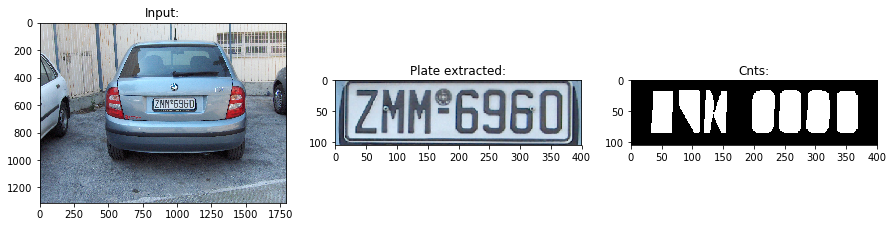

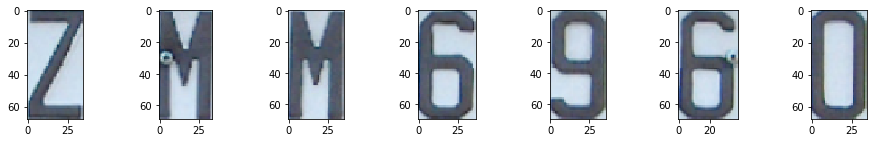

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is not found in this image


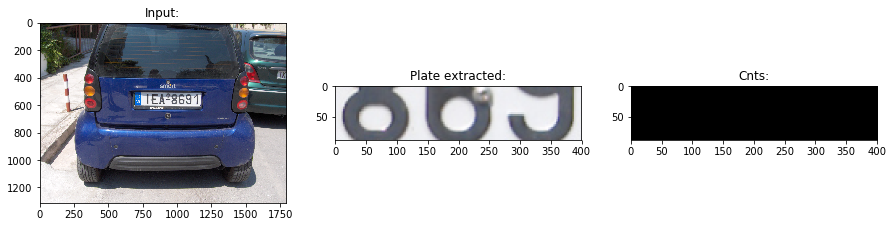

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is found in this image


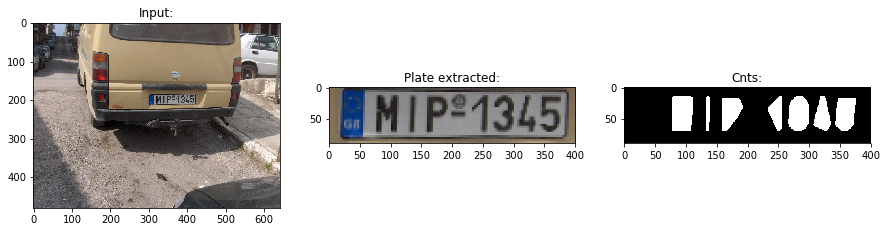

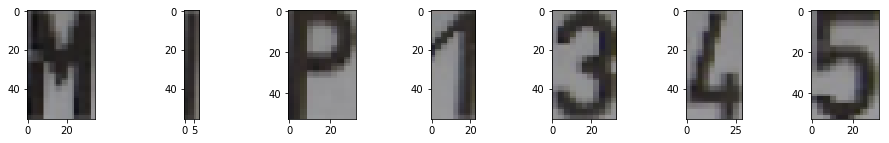

C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\skimage\filters\thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
C:\Users\User\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


A plate is not found in this image


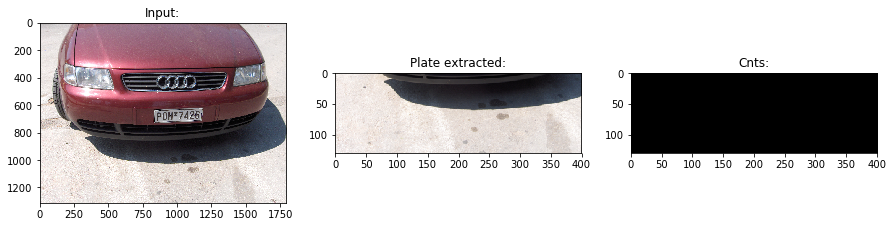

In [69]:
for name_image in list[:20]:
    image = mpImg.imread(name_image)
    detection = clsfier.detect(image)
    pltImage = detection.plate if detection != None else None
    
    if pltImage != None:
        msg = 'A plate is found in this image' if detection.success else 'A plate is not found in this image'
        print(msg)
        threshold = detection.candidates
                
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
        ax1.imshow(image)
        ax1.set_title('Input:')
        ax2.imshow(pltImage)
        ax2.set_title('Plate extracted:')
        ax3.imshow(threshold, cmap='gray')
        ax3.set_title('Cnts:')
        plt.show()
        
        sorted_cnts = clsfier.getCharacters(pltImage, threshold)
        num_plate_chars = 7
        num_cnts = len(sorted_cnts)
        diff = num_plate_chars - num_cnts
        
        if num_cnts > 0:
            _, axs = plt.subplots(1, num_cnts, figsize = (16, 2), squeeze = True)
            for index, cnt in enumerate(sorted_cnts):
                x = cnt[0]
                y = cnt[1]
                w = cnt[2]
                h = cnt[3]
                sliced_char = pltImage[y:y+h,x:x+w,:]
                axs[index].imshow(sliced_char)
            plt.show()